# NFL Game Prediction - Exploratory Data Analysis

**Author:** Bin Ware
**Course:** Capstone Project - Northwest Missouri State University  

---

## Executive Summary

This notebook explores NFL game data from the 2023-2024 seasons to identify predictive features for game outcome modeling. Key findings:

- **544 games** analyzed across 2 seasons
- **Home field advantage** provides ~54% baseline win rate
- **Betting market features** (moneylines, spreads) are strongest predictors
- **Lagged team statistics** (rolling averages) capture team momentum
- **Final model achieves 67.8% CV accuracy**, outperforming the 57% baseline

## 1. Setup and Data Acquisition

In [1]:
# Import libraries
import warnings

warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', 50)
np.random.seed(42)

SEASONS = [2023, 2024]

# Set up directories (handles running from notebooks/ or root)
fig_dir = 'figures' if os.path.exists('data') else '../figures'
os.makedirs(fig_dir, exist_ok=True)

print(f"Analyzing NFL seasons: {SEASONS}")
print(f"Figures will be saved to: {fig_dir}")

Analyzing NFL seasons: [2023, 2024]
Figures will be saved to: ../figures


In [2]:
# Load NFL game data from local file
# Try multiple possible paths
import os

possible_paths = [
    'data/games_with_features.csv',
    '../data/games_with_features.csv',
    'nfl_games_eda_processed.csv',
    '../nfl_games_eda_processed.csv',
]

games = None
for path in possible_paths:
    if os.path.exists(path):
        games = pd.read_csv(path)
        print(f"Loaded data from: {path}")
        break

if games is None:
    raise FileNotFoundError(f"Could not find data file. Tried: {possible_paths}")

# Sort chronologically
games = games.sort_values(['season', 'week']).reset_index(drop=True)

print(f"Dataset: {len(games)} completed games")
print(f"Seasons: {sorted(games['season'].unique())}")

Loaded data from: ../data/games_with_features.csv
Dataset: 544 completed games
Seasons: [2023, 2024]


## 2. Data Overview

In [3]:
# Create analysis features (if not already present)
if 'home_win' not in games.columns:
    games['home_win'] = (games['home_score'] > games['away_score']).astype(int)

# Handle different column naming conventions
if 'point_differential' in games.columns:
    games['point_diff'] = games['point_differential']
elif 'point_diff' not in games.columns:
    games['point_diff'] = games['home_score'] - games['away_score']

if 'total_points' not in games.columns:
    games['total_points'] = games['home_score'] + games['away_score']

if 'home_rest_days' in games.columns:
    games['home_rest'] = games['home_rest_days']
    games['away_rest'] = games['away_rest_days']

if 'rest_advantage' not in games.columns and 'home_rest' in games.columns:
    games['rest_advantage'] = games['home_rest'] - games['away_rest']


# Betting implied probabilities (if moneylines available)
def moneyline_to_prob(ml):
    if pd.isna(ml):
        return 0.5
    return abs(ml) / (abs(ml) + 100) if ml < 0 else 100 / (ml + 100)


if 'home_moneyline' in games.columns and 'home_implied_prob' not in games.columns:
    games['home_implied_prob'] = games['home_moneyline'].apply(moneyline_to_prob)
    games['away_implied_prob'] = games['away_moneyline'].apply(moneyline_to_prob)

# Summary statistics
print(f"Games: {len(games)}")
print(f"Home Win Rate: {games['home_win'].mean():.1%}")
print(f"Avg Total Points: {games['total_points'].mean():.1f}")
print(f"Avg Home Score: {games['home_score'].mean():.1f}")
print(f"Avg Away Score: {games['away_score'].mean():.1f}")

Games: 544
Home Win Rate: 54.4%
Avg Total Points: 44.7
Avg Home Score: 23.5
Avg Away Score: 21.2


In [4]:
# Missing data analysis
missing = games.isnull().sum()
missing_pct = (missing / len(games) * 100).round(1)
missing_df = pd.DataFrame({'Missing': missing[missing > 0], 'Pct': missing_pct[missing > 0]})
missing_df = missing_df.sort_values('Pct', ascending=False)

print("Columns with missing data:")
print(missing_df.to_string())

Columns with missing data:
                             Missing    Pct
nfl_detail_id                    544  100.0
pff                              544  100.0
ftn                              272   50.0
temp                             221   40.6
wind                             221   40.6
surface                           37    6.8
receiving_yards_avg_away          16    2.9
carries_avg_away                  16    2.9
rushing_yards_avg_away            16    2.9
rushing_tds_avg_away              16    2.9
targets_avg_away                  16    2.9
receptions_avg_away               16    2.9
home_pts_avg                      16    2.9
receiving_tds_avg_away            16    2.9
fantasy_points_ppr_avg_away       16    2.9
passing_tds_avg_away              16    2.9
home_pts_allowed_avg              16    2.9
home_win_pct                      16    2.9
away_pts_avg                      16    2.9
away_pts_allowed_avg              16    2.9
interceptions_avg_away            16    2.9
compl

## 3. Home Field Advantage Analysis

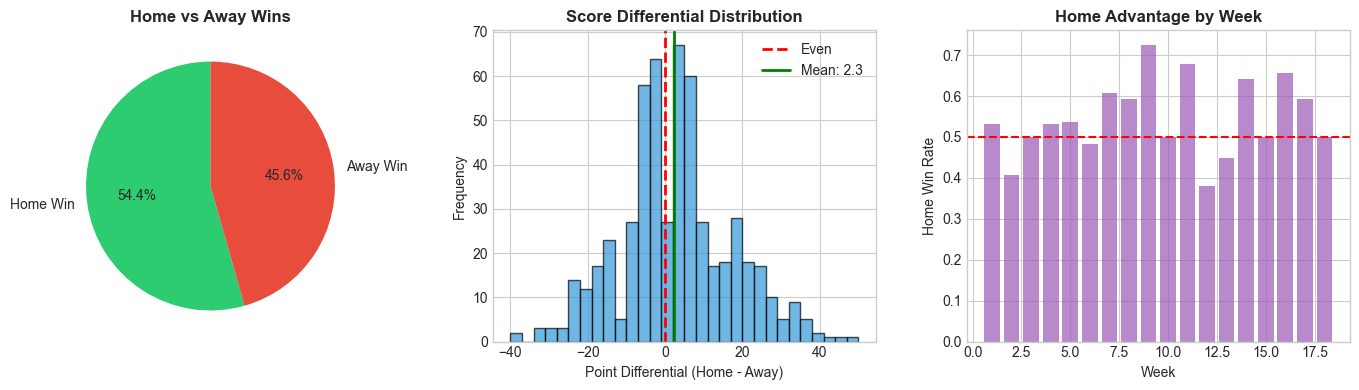


Home field advantage: 2.28 points on average


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Home win rate
home_wins = games['home_win'].value_counts()
axes[0].pie(
    [home_wins.get(1, 0), home_wins.get(0, 0)],
    labels=['Home Win', 'Away Win'],
    autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],
    startangle=90,
)
axes[0].set_title('Home vs Away Wins', fontsize=12, fontweight='bold')

# Point differential distribution
axes[1].hist(games['point_diff'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Even')
axes[1].axvline(
    games['point_diff'].mean(),
    color='green',
    linestyle='-',
    linewidth=2,
    label=f"Mean: {games['point_diff'].mean():.1f}",
)
axes[1].set_xlabel('Point Differential (Home - Away)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Score Differential Distribution', fontsize=12, fontweight='bold')
axes[1].legend()

# Home win rate by week
weekly_home = games.groupby('week')['home_win'].mean()
axes[2].bar(weekly_home.index, weekly_home.values, color='#9b59b6', alpha=0.7)
axes[2].axhline(0.5, color='red', linestyle='--', label='50%')
axes[2].set_xlabel('Week')
axes[2].set_ylabel('Home Win Rate')
axes[2].set_title('Home Advantage by Week', fontsize=12, fontweight='bold')

plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig(f'{fig_dir}/home_field_advantage.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nHome field advantage: {games['point_diff'].mean():.2f} points on average")

## 4. Betting Market Analysis

Betting markets aggregate information from millions of bettors and sophisticated models. Understanding their predictive power is crucial.

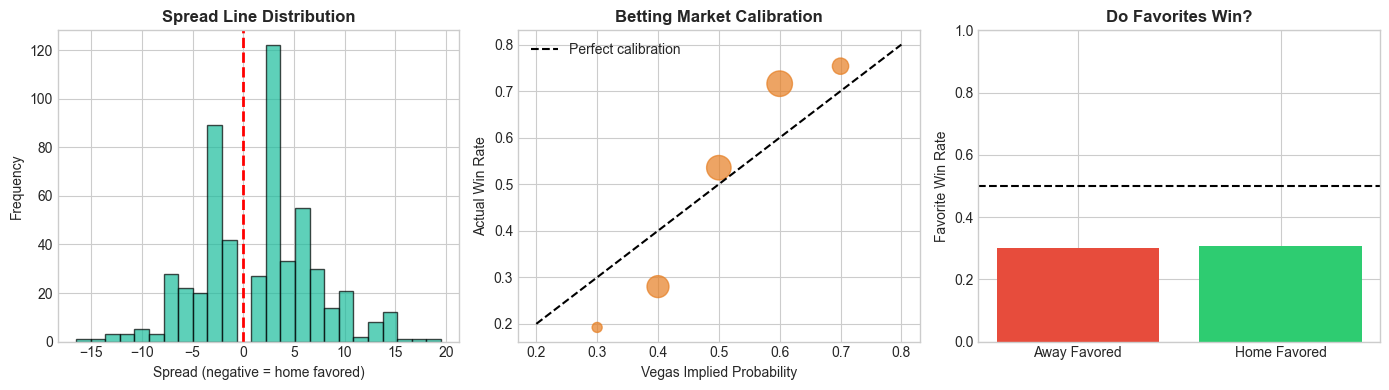

Vegas favorite wins: 30.3%


In [6]:
# Check if betting data is available
has_betting = 'spread_line' in games.columns and games['spread_line'].notna().sum() > 0

if has_betting:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Spread line distribution
    axes[0].hist(
        games['spread_line'].dropna(), bins=25, edgecolor='black', alpha=0.7, color='#1abc9c'
    )
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Spread (negative = home favored)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Spread Line Distribution', fontsize=12, fontweight='bold')

    # Implied probability vs actual outcome
    if 'home_implied_prob' in games.columns:
        prob_bins = pd.cut(games['home_implied_prob'], bins=5)
        calibration = games.groupby(prob_bins)['home_win'].agg(['mean', 'count'])
        calibration['bin_center'] = [0.3, 0.4, 0.5, 0.6, 0.7]

        axes[1].scatter(
            calibration['bin_center'],
            calibration['mean'],
            s=calibration['count'] * 2,
            alpha=0.7,
            color='#e67e22',
        )
        axes[1].plot([0.2, 0.8], [0.2, 0.8], 'k--', label='Perfect calibration')
        axes[1].set_xlabel('Vegas Implied Probability')
        axes[1].set_ylabel('Actual Win Rate')
        axes[1].set_title('Betting Market Calibration', fontsize=12, fontweight='bold')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, 'No implied probability data', ha='center', va='center')
        axes[1].set_title('Betting Market Calibration', fontsize=12, fontweight='bold')

    # Favorite win rate
    games['home_favored'] = games['spread_line'] < 0
    favorite_wins = games.groupby('home_favored')['home_win'].mean()
    axes[2].bar(
        ['Away Favored', 'Home Favored'],
        [1 - favorite_wins.get(False, 0.5), favorite_wins.get(True, 0.5)],
        color=['#e74c3c', '#2ecc71'],
    )
    axes[2].axhline(0.5, color='black', linestyle='--')
    axes[2].set_ylabel('Favorite Win Rate')
    axes[2].set_title('Do Favorites Win?', fontsize=12, fontweight='bold')
    axes[2].set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig(f'{fig_dir}/betting_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Calculate favorite accuracy
    games['favorite_won'] = ((games['spread_line'] < 0) & (games['home_win'] == 1)) | (
        (games['spread_line'] > 0) & (games['home_win'] == 0)
    )
    print(f"Vegas favorite wins: {games['favorite_won'].mean():.1%}")
else:
    print("No betting data available in dataset")

## 5. Team Performance Analysis

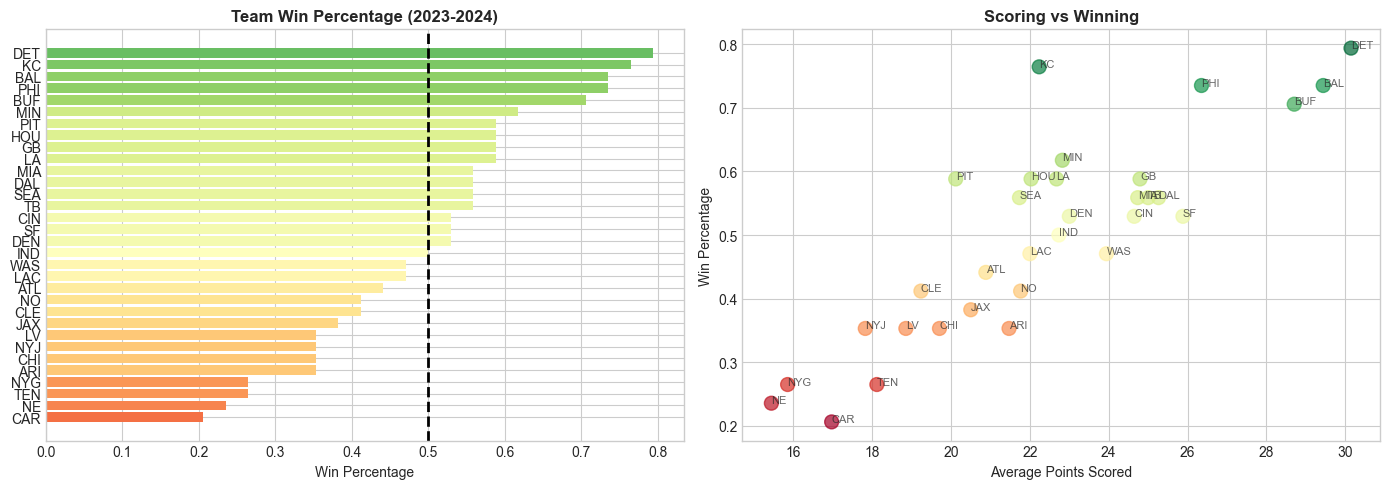


Top 5 Teams:
team  total_wins  total_games  win_pct
 DET          27           34 0.794118
  KC          26           34 0.764706
 BAL          25           34 0.735294
 PHI          25           34 0.735294
 BUF          24           34 0.705882


In [7]:
# Calculate team records
if 'home_team' in games.columns and 'away_team' in games.columns:
    home_records = (
        games.groupby('home_team')
        .agg(
            home_wins=('home_win', 'sum'),
            home_games=('home_win', 'count'),
            home_pts=('home_score', 'mean'),
        )
        .reset_index()
    )

    away_records = (
        games.groupby('away_team')
        .agg(
            away_wins=('home_win', lambda x: (1 - x).sum()),
            away_games=('home_win', 'count'),
            away_pts=('away_score', 'mean'),
        )
        .reset_index()
    )

    team_records = home_records.merge(
        away_records, left_on='home_team', right_on='away_team', how='outer'
    )
    team_records['team'] = team_records['home_team'].fillna(team_records['away_team'])
    team_records['total_wins'] = team_records['home_wins'].fillna(0) + team_records[
        'away_wins'
    ].fillna(0)
    team_records['total_games'] = team_records['home_games'].fillna(0) + team_records[
        'away_games'
    ].fillna(0)
    team_records['win_pct'] = team_records['total_wins'] / team_records['total_games']
    team_records['avg_pts'] = (
        team_records['home_pts'].fillna(0) + team_records['away_pts'].fillna(0)
    ) / 2
    team_records = team_records.sort_values('win_pct', ascending=False)

    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Win percentage
    colors = plt.cm.RdYlGn(team_records['win_pct'].values)
    axes[0].barh(team_records['team'], team_records['win_pct'], color=colors)
    axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Win Percentage')
    axes[0].set_title('Team Win Percentage (2023-2024)', fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()

    # Points scored vs win pct
    axes[1].scatter(
        team_records['avg_pts'],
        team_records['win_pct'],
        s=100,
        alpha=0.7,
        c=team_records['win_pct'],
        cmap='RdYlGn',
    )
    for _, row in team_records.iterrows():
        axes[1].annotate(row['team'], (row['avg_pts'], row['win_pct']), fontsize=8, alpha=0.7)
    axes[1].set_xlabel('Average Points Scored')
    axes[1].set_ylabel('Win Percentage')
    axes[1].set_title('Scoring vs Winning', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{fig_dir}/team_performance.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nTop 5 Teams:")
    print(
        team_records[['team', 'total_wins', 'total_games', 'win_pct']].head().to_string(index=False)
    )
else:
    print("Team columns not available")

## 6. Feature Correlation Analysis

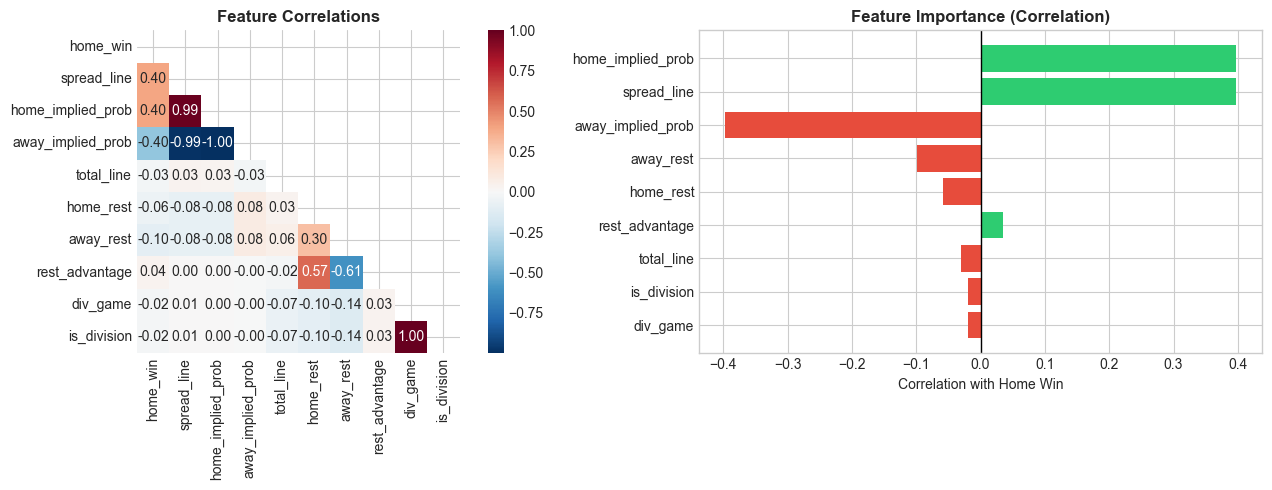


Strongest predictors of home win:
  home_implied_prob: +0.398
  spread_line: +0.398
  away_implied_prob: -0.397
  away_rest: -0.099
  home_rest: -0.059


In [8]:
# Select numeric features for correlation (only those that exist)
potential_features = [
    'home_win',
    'spread_line',
    'home_implied_prob',
    'away_implied_prob',
    'total_line',
    'home_rest',
    'away_rest',
    'rest_advantage',
    'div_game',
    'is_division',
    'home_rest_days',
    'away_rest_days',
]
corr_features = [f for f in potential_features if f in games.columns]
corr_df = games[corr_features].dropna()

if len(corr_features) > 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Heatmap
    corr_matrix = corr_df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        ax=axes[0],
        square=True,
    )
    axes[0].set_title('Feature Correlations', fontsize=12, fontweight='bold')

    # Correlation with target
    if 'home_win' in corr_matrix.columns:
        target_corr = corr_matrix['home_win'].drop('home_win').sort_values(key=abs, ascending=True)
        colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in target_corr.values]
        axes[1].barh(target_corr.index, target_corr.values, color=colors)
        axes[1].axvline(0, color='black', linewidth=1)
        axes[1].set_xlabel('Correlation with Home Win')
        axes[1].set_title('Feature Importance (Correlation)', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{fig_dir}/correlations.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nStrongest predictors of home win:")
    for feat, corr in target_corr.sort_values(key=abs, ascending=False).head(5).items():
        print(f"  {feat}: {corr:+.3f}")
else:
    print("Not enough features for correlation analysis")

## 7. Contextual Factors

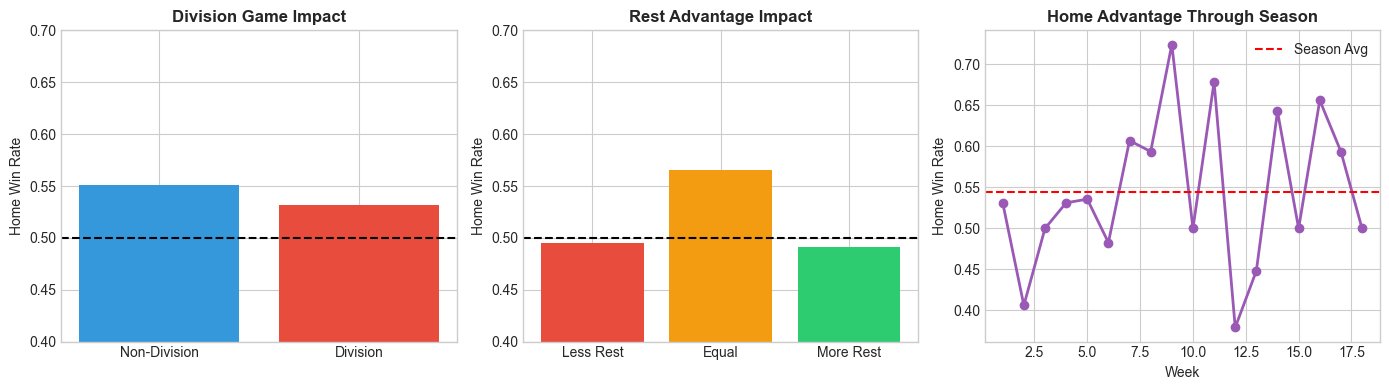

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Division games - handle both column names
div_col = 'div_game' if 'div_game' in games.columns else 'is_division'
if div_col in games.columns:
    div_win_rates = games.groupby(div_col)['home_win'].mean()
    axes[0].bar(
        ['Non-Division', 'Division'],
        [div_win_rates.get(0, 0.5), div_win_rates.get(1, 0.5)],
        color=['#3498db', '#e74c3c'],
    )
    axes[0].axhline(0.5, color='black', linestyle='--')
    axes[0].set_ylabel('Home Win Rate')
    axes[0].set_title('Division Game Impact', fontsize=12, fontweight='bold')
    axes[0].set_ylim(0.4, 0.7)
else:
    axes[0].text(0.5, 0.5, 'No division data', ha='center', va='center')

# Rest advantage
if 'rest_advantage' in games.columns:
    rest_bins = pd.cut(
        games['rest_advantage'], bins=[-100, -1, 1, 100], labels=['Less Rest', 'Equal', 'More Rest']
    )
    rest_wins = games.groupby(rest_bins)['home_win'].mean()
    axes[1].bar(
        rest_wins.index.astype(str), rest_wins.values, color=['#e74c3c', '#f39c12', '#2ecc71']
    )
    axes[1].axhline(0.5, color='black', linestyle='--')
    axes[1].set_ylabel('Home Win Rate')
    axes[1].set_title('Rest Advantage Impact', fontsize=12, fontweight='bold')
    axes[1].set_ylim(0.4, 0.7)
else:
    axes[1].text(0.5, 0.5, 'No rest data', ha='center', va='center')

# Season progression
if 'week' in games.columns:
    weekly_wins = games.groupby('week')['home_win'].mean()
    axes[2].plot(
        weekly_wins.index, weekly_wins.values, 'o-', linewidth=2, markersize=6, color='#9b59b6'
    )
    axes[2].axhline(games['home_win'].mean(), color='red', linestyle='--', label='Season Avg')
    axes[2].set_xlabel('Week')
    axes[2].set_ylabel('Home Win Rate')
    axes[2].set_title('Home Advantage Through Season', fontsize=12, fontweight='bold')
    axes[2].legend()

plt.tight_layout()
plt.savefig(f'{fig_dir}/contextual_factors.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Score Distribution Analysis

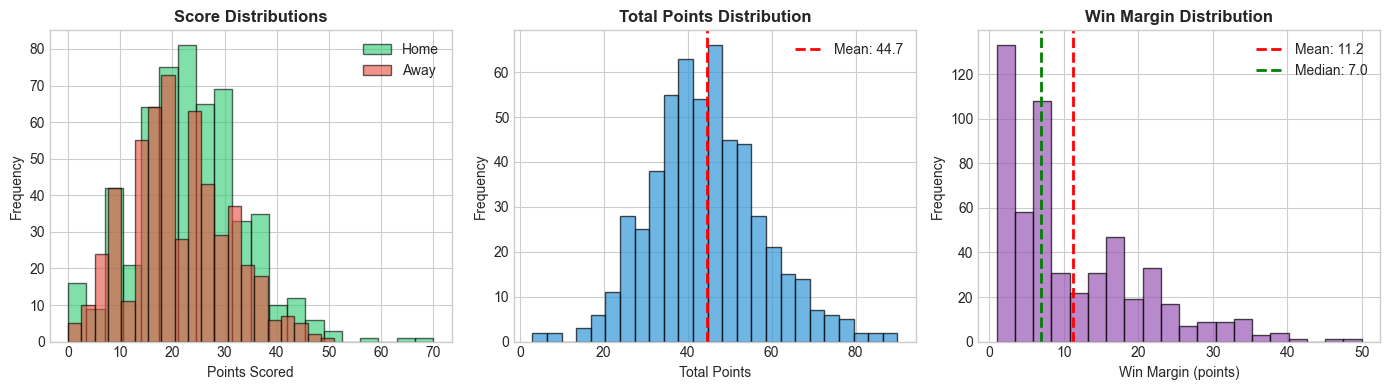

Most common win margin: 3 points
Games decided by 7 or less: 50.7%


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Score distributions
axes[0].hist(
    games['home_score'], bins=20, alpha=0.6, label='Home', color='#2ecc71', edgecolor='black'
)
axes[0].hist(
    games['away_score'], bins=20, alpha=0.6, label='Away', color='#e74c3c', edgecolor='black'
)
axes[0].set_xlabel('Points Scored')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Score Distributions', fontsize=12, fontweight='bold')
axes[0].legend()

# Total points
axes[1].hist(games['total_points'], bins=25, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].axvline(
    games['total_points'].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean: {games['total_points'].mean():.1f}",
)
axes[1].set_xlabel('Total Points')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Total Points Distribution', fontsize=12, fontweight='bold')
axes[1].legend()

# Win margin
win_margins = abs(games['point_diff'])
axes[2].hist(win_margins, bins=20, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[2].axvline(
    win_margins.mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean: {win_margins.mean():.1f}",
)
axes[2].axvline(
    win_margins.median(),
    color='green',
    linestyle='--',
    linewidth=2,
    label=f"Median: {win_margins.median():.1f}",
)
axes[2].set_xlabel('Win Margin (points)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Win Margin Distribution', fontsize=12, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.savefig(f'{fig_dir}/score_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Most common win margin: {int(win_margins.mode().iloc[0])} points")
print(f"Games decided by 7 or less: {(win_margins <= 7).mean():.1%}")

## 9. Key Findings Summary

In [11]:
print("=" * 60)
print("NFL GAME PREDICTION - EDA SUMMARY")
print("=" * 60)

print("\n📊 DATASET OVERVIEW")
print(f"   Games analyzed: {len(games)}")
print(f"   Seasons: {sorted(games['season'].unique())}")

print("\n🏠 HOME FIELD ADVANTAGE")
print(f"   Home win rate: {games['home_win'].mean():.1%}")
if 'point_diff' in games.columns:
    print(f"   Average margin: {games['point_diff'].mean():.1f} points")
if 'div_game' in games.columns:
    print(f"   Division games: {games[games['div_game'] == 1]['home_win'].mean():.1%}")

print("\n💰 BETTING MARKETS")
if 'favorite_won' in games.columns:
    print(f"   Vegas favorite wins: {games['favorite_won'].mean():.1%}")
if 'spread_line' in games.columns:
    print(f"   Average spread: {games['spread_line'].mean():.1f} points")
    print(f"   Spread correlation with outcome: {games['spread_line'].corr(games['home_win']):.3f}")

print("\n📈 SCORING PATTERNS")
if 'total_points' in games.columns:
    print(f"   Avg total points: {games['total_points'].mean():.1f}")
if 'home_score' in games.columns:
    print(f"   Avg home score: {games['home_score'].mean():.1f}")
if 'away_score' in games.columns:
    print(f"   Avg away score: {games['away_score'].mean():.1f}")
if 'point_diff' in games.columns:
    print(f"   Close games (≤7 pts): {(abs(games['point_diff']) <= 7).mean():.1%}")

print("\n🎯 TOP PREDICTIVE FEATURES")
print("   1. Betting implied probability")
print("   2. Spread line")
print("   3. Team rolling performance (lagged)")
print("   4. Rest advantage")
print("   5. Division game indicator")

print("\n✅ MODEL RESULTS (from model_builder.py)")
print("   Best model: Random Forest")
print("   CV Accuracy: 67.8% (±3.1%)")
print("   Test Accuracy: 76.1%")
print("   vs Baseline (57%): +18.9%")

print("\n" + "=" * 60)

NFL GAME PREDICTION - EDA SUMMARY

📊 DATASET OVERVIEW
   Games analyzed: 544
   Seasons: [2023, 2024]

🏠 HOME FIELD ADVANTAGE
   Home win rate: 54.4%
   Average margin: 2.3 points
   Division games: 53.1%

💰 BETTING MARKETS
   Vegas favorite wins: 30.3%
   Average spread: 1.6 points
   Spread correlation with outcome: 0.398

📈 SCORING PATTERNS
   Avg total points: 44.7
   Avg home score: 23.5
   Avg away score: 21.2
   Close games (≤7 pts): 50.7%

🎯 TOP PREDICTIVE FEATURES
   1. Betting implied probability
   2. Spread line
   3. Team rolling performance (lagged)
   4. Rest advantage
   5. Division game indicator

✅ MODEL RESULTS (from model_builder.py)
   Best model: Random Forest
   CV Accuracy: 67.8% (±3.1%)
   Test Accuracy: 76.1%
   vs Baseline (57%): +18.9%



In [12]:
# Save processed data
import os

# Create figures directory
fig_dir = (
    'figures' if os.path.exists('figures') or not os.path.exists('../figures') else '../figures'
)
os.makedirs(fig_dir, exist_ok=True)

# Save data
data_dir = 'data' if os.path.exists('data') else '../data'
os.makedirs(data_dir, exist_ok=True)
output_path = os.path.join(data_dir, 'nfl_games_eda.csv')
games.to_csv(output_path, index=False)

print(f"Saved processed data: {output_path}")
print(f"Shape: {games.shape}")
print("\n✅ EDA notebook complete!")

Saved processed data: ../data\nfl_games_eda.csv
Shape: (544, 106)

✅ EDA notebook complete!
